# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
init_notebook_mode(connected=True)

NameError: ignored

In [2]:
!pip3 install dask
!pip install graphviz
!pip install folium
!pip install gpxpy
!pip install gensim
!pip install prettytable
!pip install sklearn
!pip install dask[complete]
!pip3 install plotly 
!pip install dash==0.35.1  # The core dash backend
!pip install dash-html-components==0.13.4  # HTML components
!pip install dash-core-components==0.42.1  # Supercharged components
!pip3 install dash-table==3.1.11
!pip install scikit-plot

    100% |████████████████████████████████| 112kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/7c/81/7f/effefbec600ee0ba7f29a29e38754a6e4e1e956538929fdbfd
Successfully built gpxpy
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket
    100% |████████████████████████████████| 942kB 20.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/5a/c8/61/4daf9b3c3b33e8037294f3e694b84b2a6e04cf1d7ab6724fa5
  Stored in directory: /root/.cache/pip/wheels/96/32/88/a1f6d9dd3c29570ab3a8acc0d556b3b20abcf3c623c868ce0a
  Stored in directory: /root/.cache/pip/wheels/09/d2/49/0d140766d5ee1ef4ce271d302a5d30cf3d18c5b507e48c77f3
Successfully built dash flask-compress dash-renderer
    100% |████████████████████████████████| 532kB 24.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/23/32/a4/73402d8718ad5e92e9d47dcfa088be5481961e2b562ea09803
Successfully built dash-html-components
    100% |█████████████████████████

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite') 

In [6]:
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']

def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)


filteredData['Score']=dfPositiveNegative
print(filteredData.head(5))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [9]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape
print(final.head(5))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   E

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
                
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string

In [0]:
final=final.sort_values(by='Time')

In [0]:
final_new=final

In [16]:
final=final.iloc[0:100000,:]
final.shape

(100000, 11)

In [17]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
final.shape

(100000, 12)

In [0]:
X_train=final.iloc[0:45000]
Y_train=final['Score_num'].iloc[0:45000]

In [0]:
X_test=final.iloc[45001:60000]
Y_test=final['Score_num'].iloc[45001:60000]

# tfidF

In [0]:
count_vect = TfidfVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect=count_vect.transform(X_test['CleanedText'].values)

In [23]:
print(X_train_vect.shape)

(45000, 25812)


In [0]:
from sklearn.preprocessing import Normalizer
transformer_tfidf = Normalizer().fit(X_train_vect)
X_train_vect_norm_tfidf=transformer_tfidf.transform(X_train_vect)

In [0]:
X_test_vect_norm_tfidf=transformer_tfidf.transform(X_test_vect)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# BOW

In [0]:
count_vect_bow=CountVectorizer() #in scikit-learn
X_train_vect_bow = count_vect_bow.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect_bow=count_vect_bow.transform(X_test['CleanedText'].values)

In [29]:
from sklearn.preprocessing import Normalizer
transformer_bow = Normalizer().fit(X_train_vect_bow)
print(transformer_bow)
X_train_vect_norm_bow=transformer_bow.transform(X_train_vect_bow)
X_test_vect_norm_bow=transformer_bow.transform(X_test_vect_bow)

Normalizer(copy=True, norm='l2')


# word2vec

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [31]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
X_train_word2vec=final.iloc[0:45000]
Y_train_word2vec=final['Score_num'].iloc[0:45000]

X_test_word2vec=final.iloc[45001:60000]
Y_test_word2vec=final['Score_num'].iloc[45001:60000]

In [0]:
list_of_sent_X_train_word2vec=[]
list_of_sent_X_test_word2vec=[]

for sent in X_train_word2vec['CleanedText'].values:
    list_of_sent_X_train_word2vec.append(sent.split())
    


for sent in X_test_word2vec['CleanedText'].values:
    list_of_sent_X_test_word2vec.append(sent.split())

In [34]:
print(list_of_sent_X_train_word2vec)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
w2v_model=Word2Vec(list_of_sent_X_train_word2vec,min_count=5,size=50, workers=4)

In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
            #print(cnt_words)
            #print(word)
    
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

In [0]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_word2vec = Normalizer().fit(sent_vectors_train)
X_train_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_train)
X_test_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_test)

# tfidf word2vec

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
    #print(sent_vec)
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [41]:
from sklearn.preprocessing import Normalizer
transformer_tfidfword2vec = Normalizer().fit(tfidf_sent_vectors_train)
print(transformer_word2vec)
tfidf_sent_vectors_train_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_test_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_test)

Normalizer(copy=True, norm='l2')


In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

#Random forest 

TFIDF RF

In [0]:
tuned_parameters = [{'max_depth': [10,50,80,100],'n_estimators': [100,500,700,1000]}]
cv_scores = []
clf = RandomForestClassifier(criterion='gini',max_features='log2',min_samples_leaf=4)
model_auc_tfidf = GridSearchCV(clf,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc',n_jobs=-1)
model_auc_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [10, 50, 80, 100], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
print("best estimator",model_auc_tfidf.best_estimator_)
print("Score",model_auc_tfidf.score(X_test_vect_norm_tfidf, Y_test))
print(model_auc_tfidf.best_params_)

best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Score 0.9011364144556667
{'max_depth': 100, 'n_estimators': 1000}


In [0]:
cv_auc_train = model_auc_tfidf.cv_results_['mean_train_score']
cv_auc_cv=model_auc_tfidf.cv_results_['mean_test_score']

In [0]:
print(len(cv_auc_train))
print(len(cv_auc_cv))
print(model_auc_tfidf.cv_results_['params'][0])

16
16
{'max_depth': 10, 'n_estimators': 100}


In [0]:
max_depth=[]
n_estimators=[]
for data in model_auc_tfidf.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  n_estimators.append(data['n_estimators'])
 

In [0]:
#df1=pd.DataFrame(a[1])
#b = df1.pivot('max_depth','n_estimators','cv_auc_train')
df_train_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train': cv_auc_train
    })


In [0]:
df_train_tfidf = df_train_tfidf.pivot("max_depth", "n_estimators", "cv_auc_train")

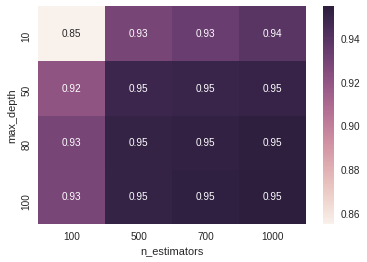

In [0]:
ax = sns.heatmap(df_train_tfidf,annot=True)

In [0]:
df_cv_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv': cv_auc_cv
    })
df_cv_tfidf = df_cv_tfidf.pivot("max_depth", "n_estimators", "cv_auc_cv")

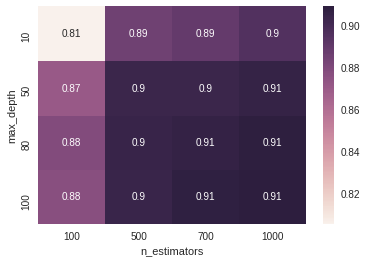

In [0]:
ax = sns.heatmap(df_cv_tfidf,annot=True)

In [0]:
clf_model_tfidf = RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=700)

clf_model_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

Y_predict_tfidf=clf_model_tfidf.predict(X_test_vect_norm_tfidf)

Y_prob_tfidf=clf_model_tfidf.predict_proba(X_test_vect_norm_tfidf)


In [0]:
feature_weights_tfidf=clf_model_tfidf.feature_importances_
indices_tfidf = np.argsort(feature_weights_tfidf)[::-1][:20]
tfidf_features = count_vect.get_feature_names()
#tfidf_features[data for data in indices_tfidf]

In [0]:
tfidf_features_arr=[]
for data in indices_tfidf:
  tfidf_features_arr.append(tfidf_features[data])

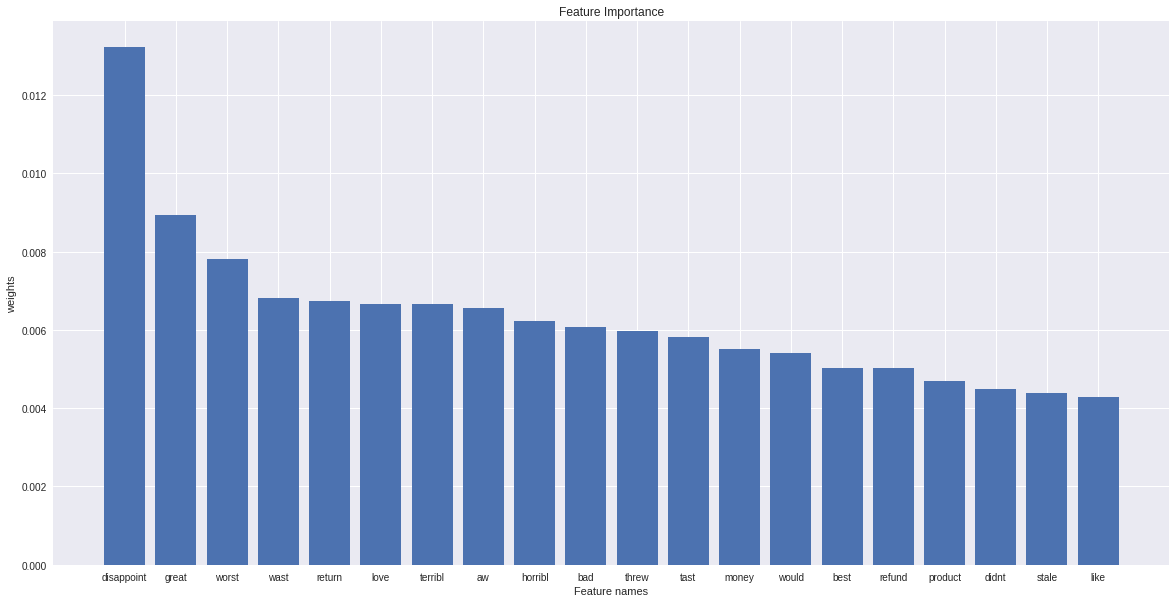

In [0]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_tfidf[indices_tfidf])

# Add feature names as x-axis labels
tfidf_features = np.array(tfidf_features)
plt.xticks(range(20), tfidf_features[indices_tfidf])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()

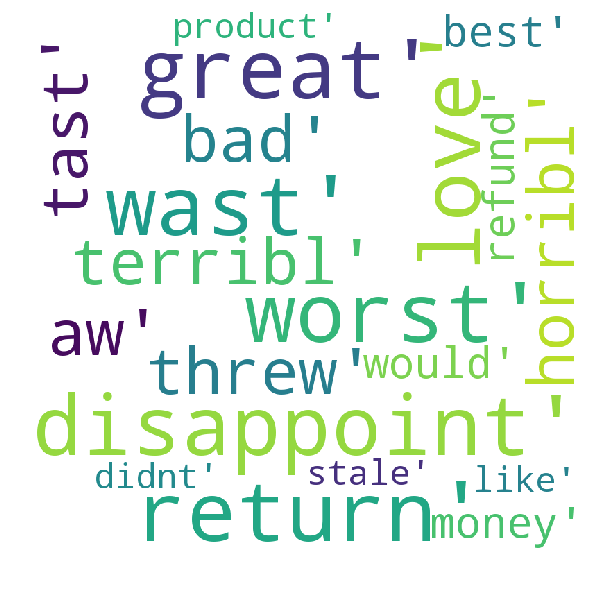

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(tfidf_features_arr)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidf[:,1])

In [0]:
print("AUC",metrics.auc(fpr, tpr))

AUC 0.901686692853918


In [0]:
import scikitplot as skplt

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


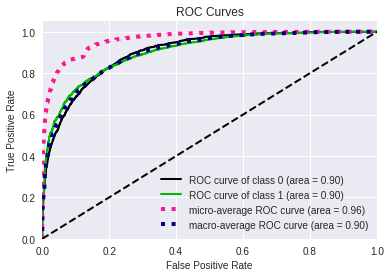

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(Y_test, Y_prob_tfidf)
plt.show()

-------------------- Confusion matrix --------------------


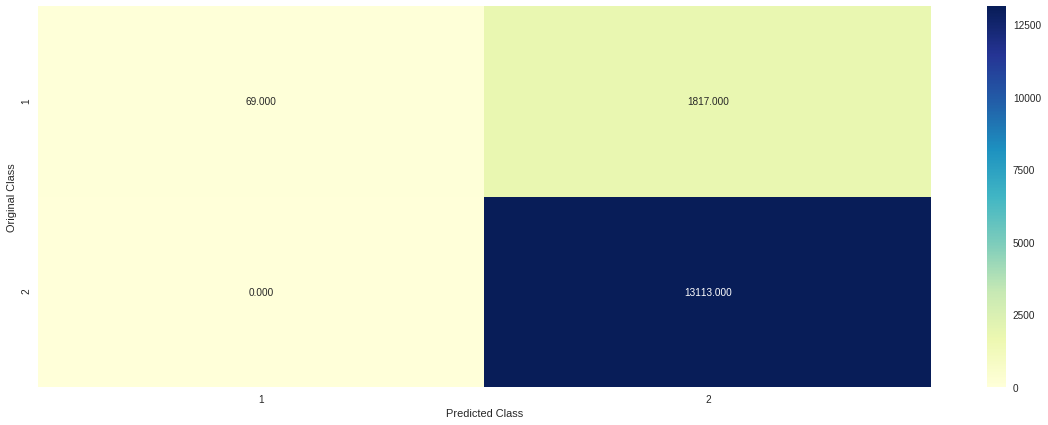

-------------------- Precision matrix (Columm Sum=1) --------------------


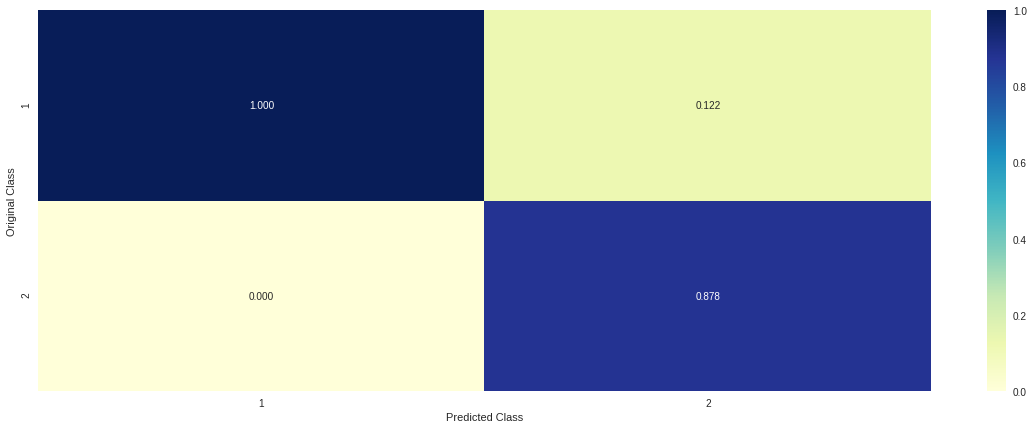

-------------------- Recall matrix (Row sum=1) --------------------


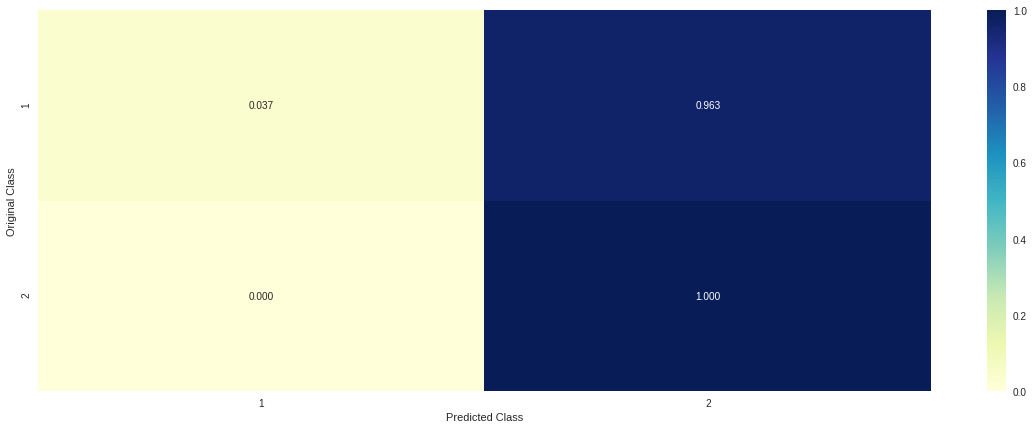

In [0]:
plot_confusion_matrix(Y_test,Y_predict_tfidf)

# BOW Random Forest

In [0]:
tuned_parameters = [{'max_depth': [10,50,80,100],'n_estimators': [100,500,700,1000]}]

clf_bow = RandomForestClassifier(criterion='gini',max_features='log2',min_samples_leaf=4,n_jobs=-1)

model_auc_bow = GridSearchCV(clf_bow,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')

model_auc_bow.fit(X_train_vect_norm_bow, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [10, 50, 80, 100], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
cv_auc_train_bow = model_auc_bow.cv_results_['mean_train_score']
cv_auc_cv_bow=model_auc_bow.cv_results_['mean_test_score']
print(cv_auc_train_bow)
print(cv_auc_cv_bow)

[0.85047854 0.92812775 0.9358096  0.9392744  0.92431318 0.94980948
 0.95178697 0.95305291 0.9296547  0.95197785 0.95352724 0.95433436
 0.9306617  0.95307518 0.954496   0.95618353]
[0.80017214 0.88313196 0.89181432 0.89608573 0.87140996 0.90576436
 0.90684437 0.90925278 0.87883834 0.90707997 0.90953676 0.90915997
 0.88023787 0.90561318 0.90860361 0.91118463]


In [0]:
print("Score",model_auc_bow.score(X_test_vect_norm_bow,Y_test))
print("Best parameters",model_auc_bow.best_params_)

Score 0.8991958632844663
Best parameters {'max_depth': 100, 'n_estimators': 1000}


In [0]:
df_train_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_bow': cv_auc_train_bow
    })

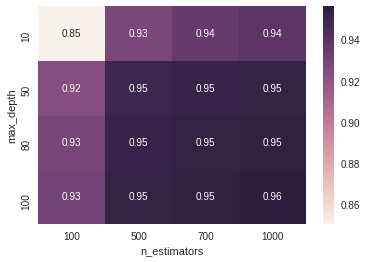

In [0]:
df_train_bow = df_train_bow.pivot("max_depth", "n_estimators", "cv_auc_train_bow")

ax = sns.heatmap(df_train_bow,annot=True)

In [0]:
df_cv_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_bow': cv_auc_cv_bow
    })
df_cv_bow = df_cv_bow.pivot("max_depth", "n_estimators", "cv_auc_cv_bow")

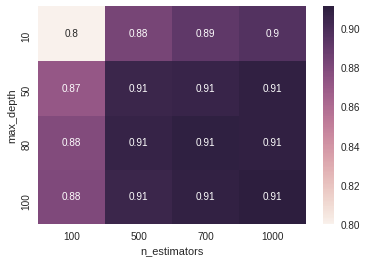

In [0]:
ax = sns.heatmap(df_cv_bow,annot=True)

In [0]:
clf_model_bow = RandomForestClassifier(criterion='gini',max_depth=80,n_estimators=700)

clf_model_bow.fit(X_train_vect_norm_bow, Y_train)

Y_predict_bow=clf_model_bow.predict(X_test_vect_norm_bow)
Y_prob_bow=clf_model_bow.predict_proba(X_test_vect_norm_bow)

In [0]:
feature_weights_bow=clf_model_bow.feature_importances_
bow_features = count_vect_bow.get_feature_names()

indices_bow = np.argsort(feature_weights_bow)[::-1][:20]

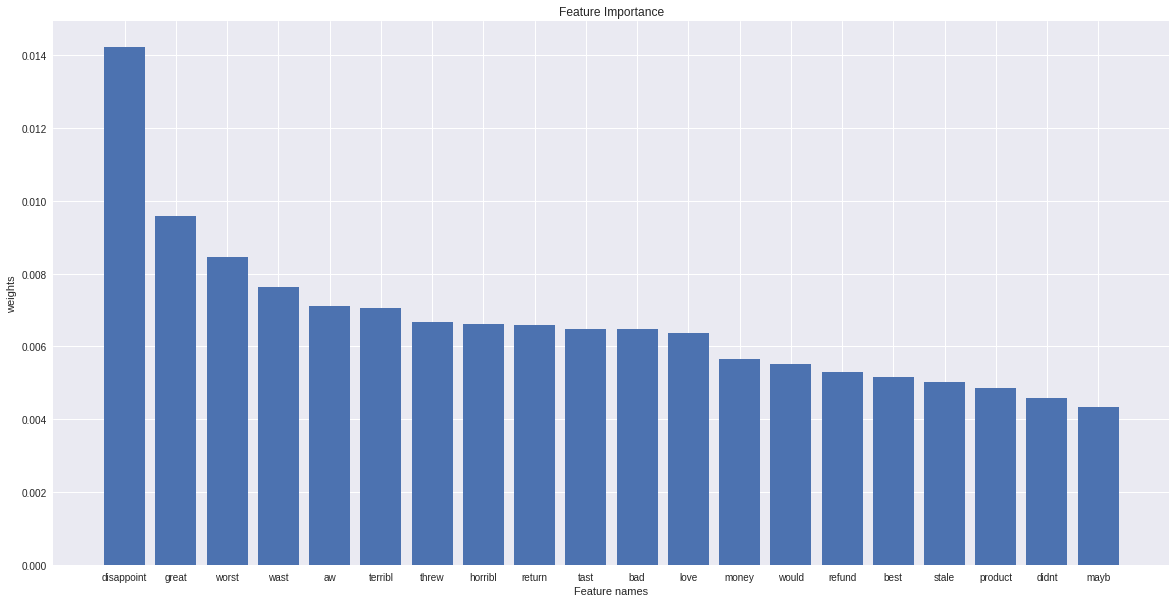

In [0]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_bow[indices_bow])

# Add feature names as x-axis labels
bow_features = np.array(bow_features)
plt.xticks(range(20), bow_features[indices_bow])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()

In [0]:
bow_features_arr=[]
for data in indices_bow:
  bow_features_arr.append(bow_features[data])

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_bow[:,1])
print("AUC",metrics.auc(fpr, tpr))


AUC 0.9038084731955911


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


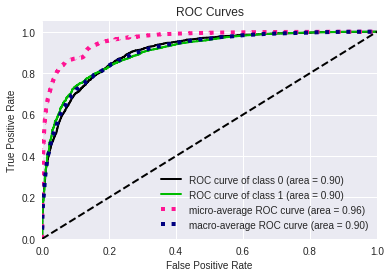

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(Y_test, Y_prob_bow)
plt.show()

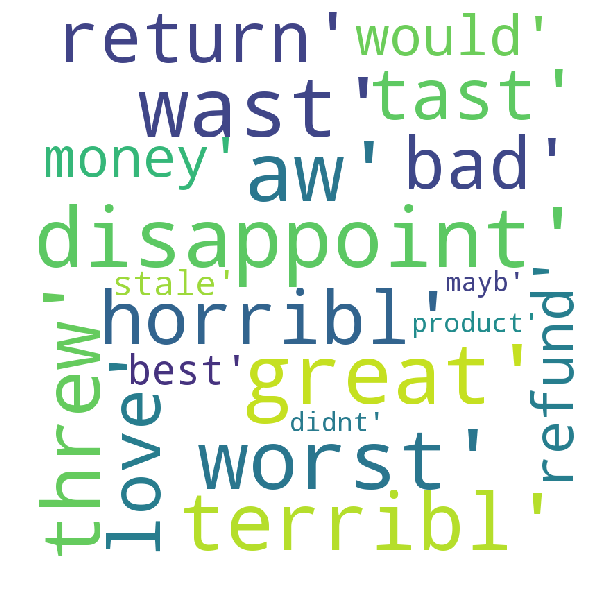

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(bow_features_arr)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

-------------------- Confusion matrix --------------------


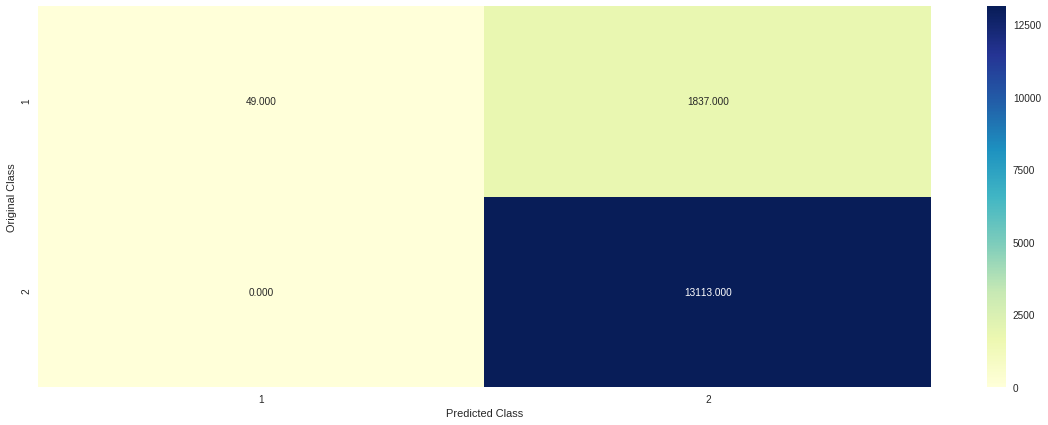

-------------------- Precision matrix (Columm Sum=1) --------------------


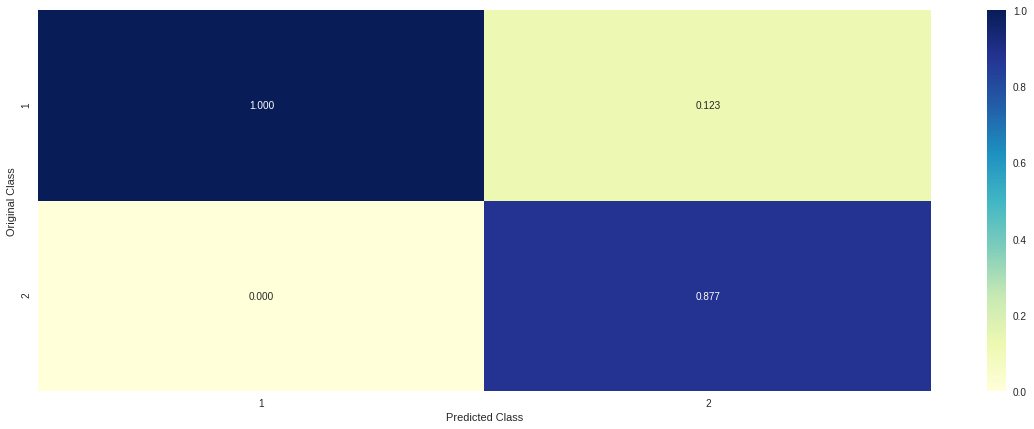

-------------------- Recall matrix (Row sum=1) --------------------


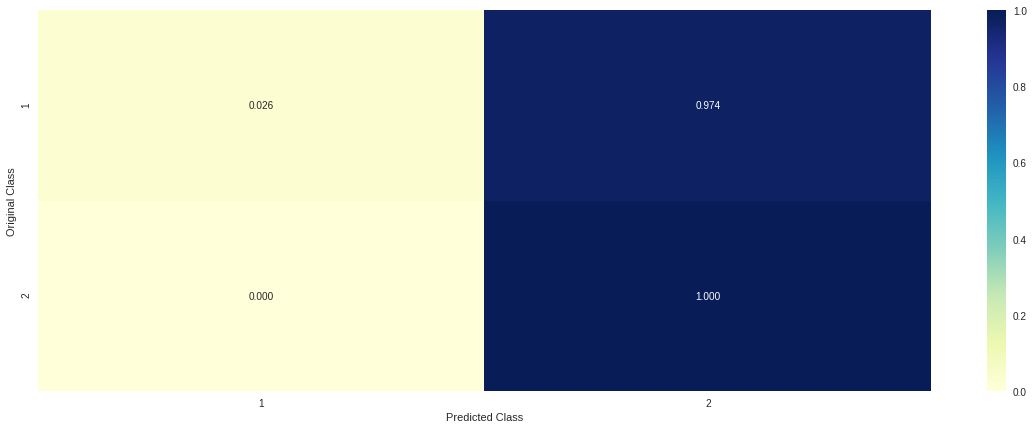

In [0]:
plot_confusion_matrix(Y_test,Y_predict_bow)

word2vec

In [0]:
tuned_parameters = [{'max_depth': [10,50,80,100],'n_estimators': [100,500,700,1000]}]

clf_word2vec = RandomForestClassifier(criterion='gini',max_features='log2',min_samples_leaf=4,n_jobs=-1)

model_auc_word2vec = GridSearchCV(clf_word2vec,tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc',n_jobs=-1)
model_auc_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [10, 50, 80, 100], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
cv_auc_train_word2vec = model_auc_word2vec.cv_results_['mean_train_score']
cv_auc_cv_word2vec=model_auc_word2vec.cv_results_['mean_test_score']
print(cv_auc_train_word2vec)
print(cv_auc_train_word2vec)

[0.97326107 0.97490604 0.97517462 0.97516735 0.99952206 0.99965706
 0.99966246 0.99968036 0.99952119 0.99966183 0.99967012 0.99967112
 0.99952133 0.99966999 0.99967374 0.99967803]
[0.97326107 0.97490604 0.97517462 0.97516735 0.99952206 0.99965706
 0.99966246 0.99968036 0.99952119 0.99966183 0.99967012 0.99967112
 0.99952133 0.99966999 0.99967374 0.99967803]


In [0]:
print("Score",model_auc_word2vec.score(X_test_vect_norm_word2vec,Y_test))
print("Best parameters",model_auc_word2vec.best_params_)

Score 0.868364543810757
Best parameters {'max_depth': 50, 'n_estimators': 1000}


In [0]:
df_train_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_word2vec': cv_auc_train_word2vec
    })

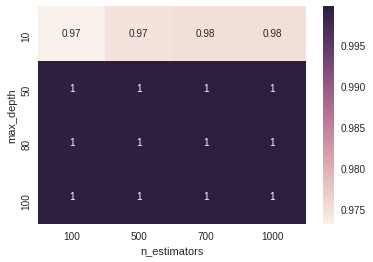

In [0]:
df_train_word2vec = df_train_word2vec.pivot("max_depth", "n_estimators", "cv_auc_train_word2vec")

ax = sns.heatmap(df_train_word2vec,annot=True)

In [0]:
df_cv_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_word2vec': cv_auc_cv_word2vec
    })

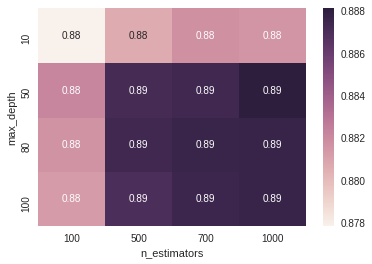

In [0]:
df_cv_word2vec = df_cv_word2vec.pivot("max_depth", "n_estimators", "cv_auc_cv_word2vec")

ax = sns.heatmap(df_cv_word2vec,annot=True)

In [0]:
clf_model_word2vec = RandomForestClassifier(criterion='gini',max_depth=50,n_estimators=1000)

clf_model_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

Y_predict_word2vec=clf_model_word2vec.predict(X_test_vect_norm_word2vec)

Y_prob_word2vec=clf_model_word2vec.predict_proba(X_test_vect_norm_word2vec)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_word2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))


AUC 0.8644742829660996


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


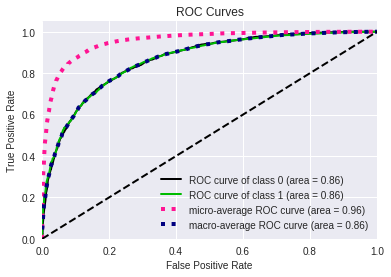

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(Y_test, Y_prob_word2vec)
plt.show()

-------------------- Confusion matrix --------------------


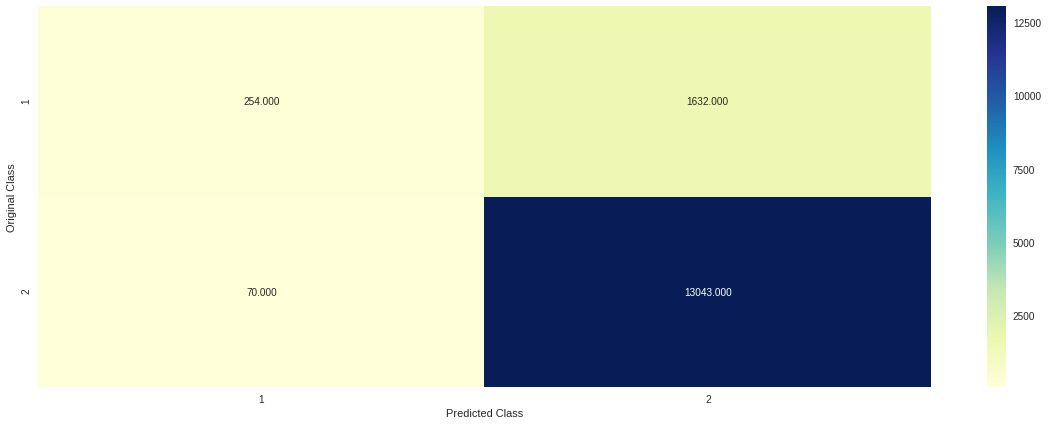

-------------------- Precision matrix (Columm Sum=1) --------------------


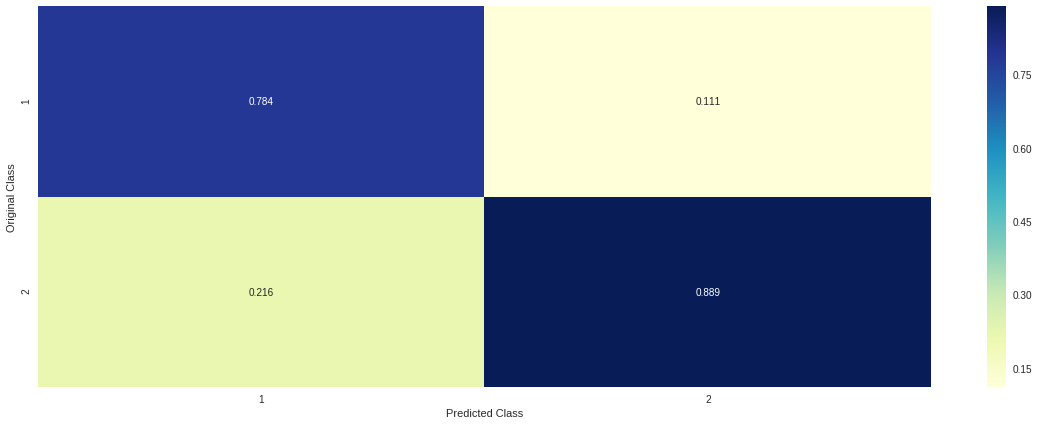

-------------------- Recall matrix (Row sum=1) --------------------


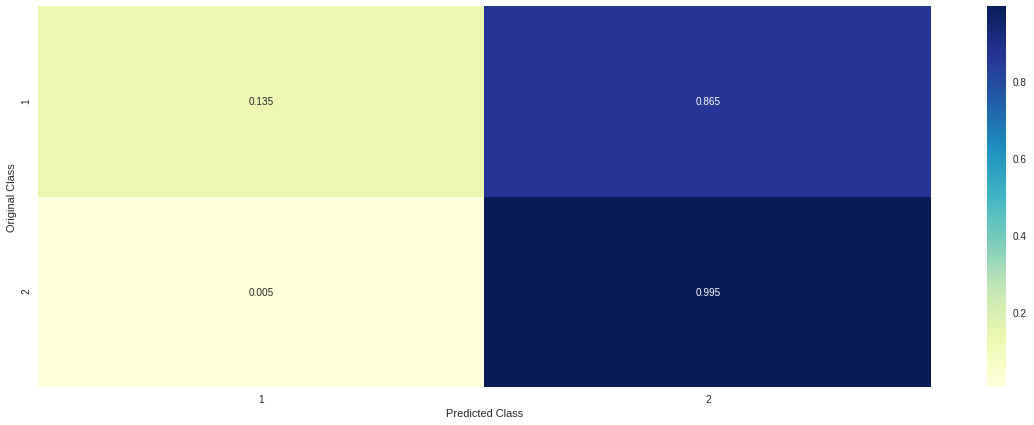

In [0]:
plot_confusion_matrix(Y_test,Y_predict_word2vec)

tfidf word2vec

In [0]:
tuned_parameters = [{'max_depth': [10,50,80,100],'n_estimators': [100,500,700,1000]}]

clf_tfidfword2vec = RandomForestClassifier(criterion='gini',max_features='log2',min_samples_leaf=4,n_jobs=-1)

clf_tfidfword2vec = GridSearchCV(clf_tfidfword2vec,tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')
clf_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [10, 50, 80, 100], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
cv_auc_train_tfidfword2vec = clf_tfidfword2vec.cv_results_['mean_train_score']
cv_auc_cv_tfidfword2vec=clf_tfidfword2vec.cv_results_['mean_test_score']
print(cv_auc_train_tfidfword2vec)
print(cv_auc_train_tfidfword2vec)

[0.96698922 0.96947757 0.96979586 0.96960484 0.99951186 0.99965826
 0.99967976 0.99967187 0.99947275 0.99965371 0.99966597 0.99967175
 0.99947392 0.99966512 0.99968248 0.99967511]
[0.96698922 0.96947757 0.96979586 0.96960484 0.99951186 0.99965826
 0.99967976 0.99967187 0.99947275 0.99965371 0.99966597 0.99967175
 0.99947392 0.99966512 0.99968248 0.99967511]


In [0]:
print("Score",clf_tfidfword2vec.score(tfidf_sent_vectors_test_norm,Y_test))
print("Best parameters",clf_tfidfword2vec.best_params_)

Score 0.8368817374127607
Best parameters {'max_depth': 50, 'n_estimators': 1000}


In [0]:
max_depth=[]
n_estimators=[]
for data in clf_tfidfword2vec.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  n_estimators.append(data['n_estimators'])

In [0]:
df_train_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_tfidfword2vec': cv_auc_train_tfidfword2vec
    })

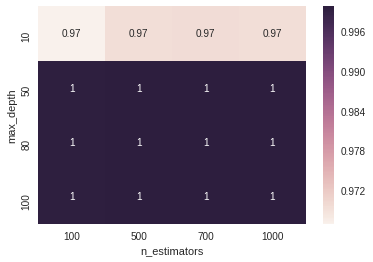

In [0]:
df_train_tfidfword2vec = df_train_tfidfword2vec.pivot('max_depth','n_estimators','cv_auc_train_tfidfword2vec')

ax = sns.heatmap(df_train_tfidfword2vec,annot=True)

In [0]:
df_cv_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_tfidfword2vec': cv_auc_cv_tfidfword2vec
    })

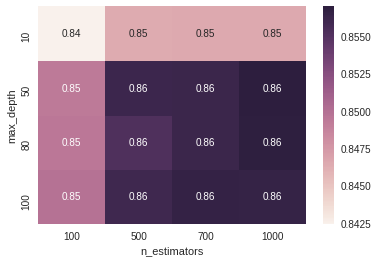

In [0]:
df_cv_tfidfword2vec = df_cv_tfidfword2vec.pivot("max_depth", "n_estimators", "cv_auc_cv_tfidfword2vec")

ax = sns.heatmap(df_cv_tfidfword2vec,annot=True)

In [0]:
clf_model_tfidfword2vec = RandomForestClassifier(criterion='gini',max_depth=50,n_estimators=1000)

clf_model_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

Y_predict_tfidfword2vec=clf_model_tfidfword2vec.predict(tfidf_sent_vectors_test_norm)

Y_prob_tfidfword2vec=clf_model_tfidfword2vec.predict_proba(tfidf_sent_vectors_test_norm)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidfword2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.8354818613537811


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


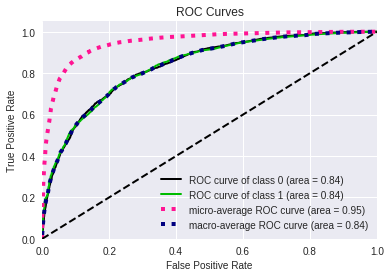

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(Y_test, Y_prob_tfidfword2vec)
plt.show()

-------------------- Confusion matrix --------------------


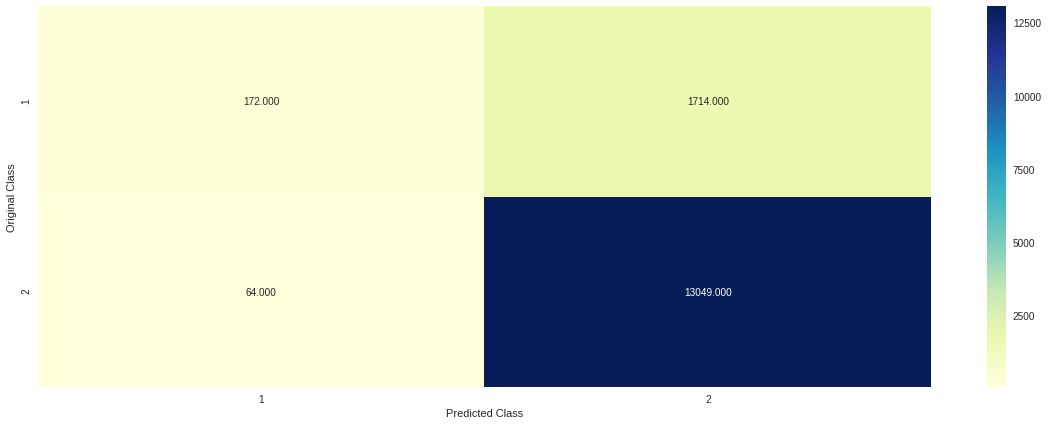

-------------------- Precision matrix (Columm Sum=1) --------------------


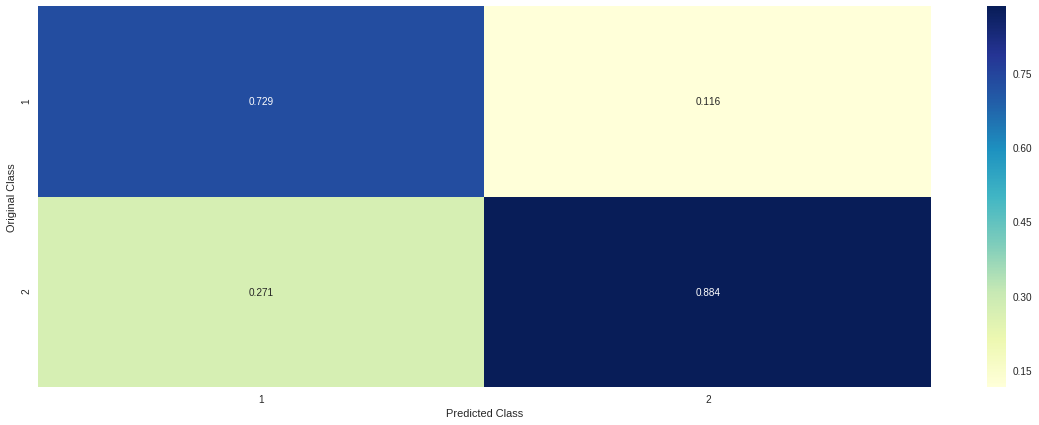

-------------------- Recall matrix (Row sum=1) --------------------


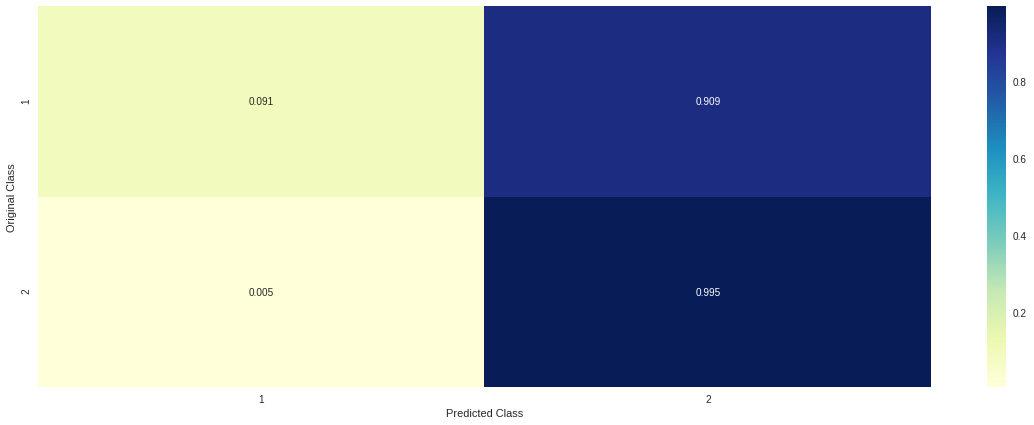

In [0]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

#GBDT

TFIDF GBDT

In [0]:
from xgboost import XGBClassifier

In [0]:
tuned_parameters = [{'max_depth': [10,20,40,80],'n_estimators': [100,500,700,1000]}]
cv_scores = []
#clf = GradientBoostingClassifier(max_features='log2',min_samples_leaf=4)
clf=XGBClassifier()
model_auc_tfidf = GridSearchCV(clf,tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc',n_jobs=-1)
model_auc_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

In [0]:
print("best estimator",model_auc_tfidf.best_estimator_)
print("Score",model_auc_tfidf.score(X_test_vect_norm_tfidf, Y_test))
print(model_auc_tfidf.best_params_)

In [0]:
cv_auc_train = model_auc_tfidf.cv_results_['mean_train_score']
cv_auc_cv=model_auc_tfidf.cv_results_['mean_test_score']

In [0]:
print(len(cv_auc_train))
print(len(cv_auc_cv))
print(model_auc_tfidf.cv_results_['params'][0])

In [0]:
max_depth=[]
n_estimators=[]
for data in model_auc_tfidf.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  n_estimators.append(data['n_estimators'])

In [0]:
df_train_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train': cv_auc_train
    })

In [0]:
df_train_tfidf = df_train_tfidf.pivot("max_depth", "n_estimators", "cv_auc_train")
ax = sns.heatmap(df_train_tfidf,annot=True)

In [0]:
df_cv_tfidf = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv': cv_auc_cv
    })
df_cv_tfidf = df_cv_tfidf.pivot("max_depth", "n_estimators", "cv_auc_cv")

In [0]:
ax = sns.heatmap(df_cv_tfidf,annot=True)

In [0]:
clf_model_tfidf=XGBClassifier(max_depth=10,n_estimators=1000)
#clf_model_tfidf = RandomForestClassifier(criterion='gini',max_depth=80,n_estimators=700)

clf_model_tfidf.fit(X_train_vect_norm_tfidf, Y_train)

Y_predict_tfidf=clf_model_tfidf.predict(X_test_vect_norm_tfidf)

Y_prob_tfidf=clf_model_tfidf.predict_proba(X_test_vect_norm_tfidf)

In [0]:
feature_weights_tfidf=clf_model_tfidf.feature_importances_
indices_tfidf = np.argsort(feature_weights_tfidf)[::-1][:20]
tfidf_features = count_vect.get_feature_names()
#tfidf_features[data for data in indices_tfidf]

In [0]:
tfidf_features_arr=[]
for data in indices_tfidf:
  tfidf_features_arr.append(tfidf_features[data])

In [0]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_tfidf[indices_tfidf])
# Add feature names as x-axis labels
tfidf_features = np.array(tfidf_features)
plt.xticks(range(20), tfidf_features[indices_tfidf])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(tfidf_features_arr))

In [0]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidf[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.9191309102968981


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


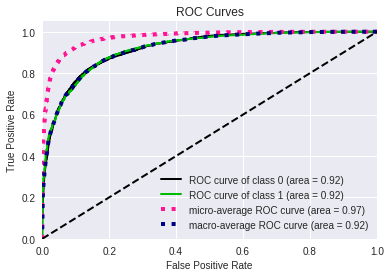

In [0]:
skplt.metrics.plot_roc_curve(Y_test, Y_prob_tfidf)
plt.show()

-------------------- Confusion matrix --------------------


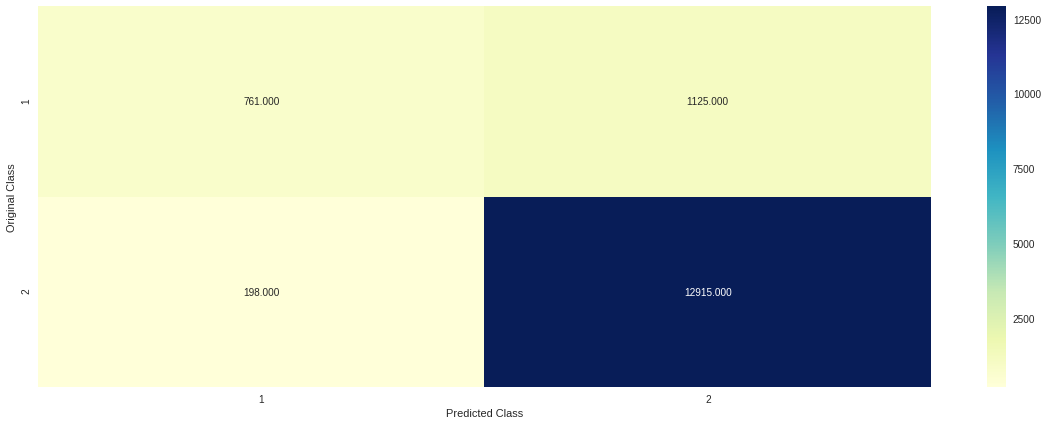

-------------------- Precision matrix (Columm Sum=1) --------------------


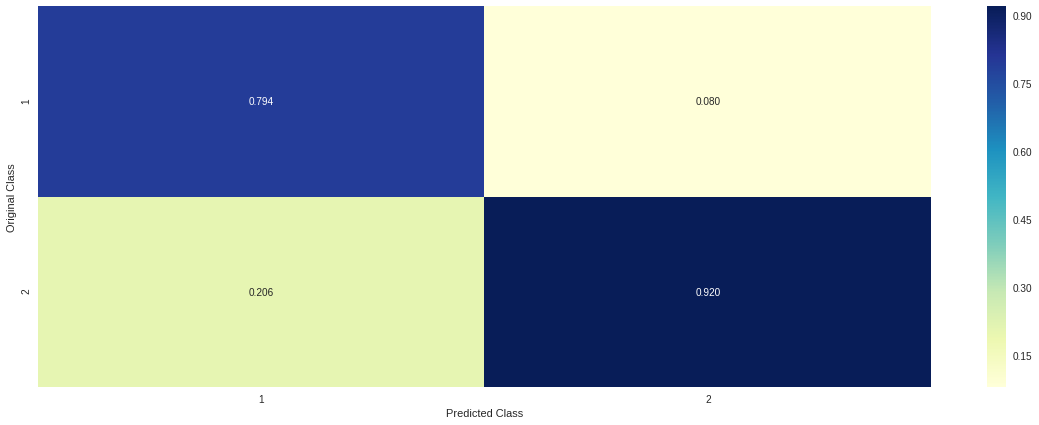

-------------------- Recall matrix (Row sum=1) --------------------


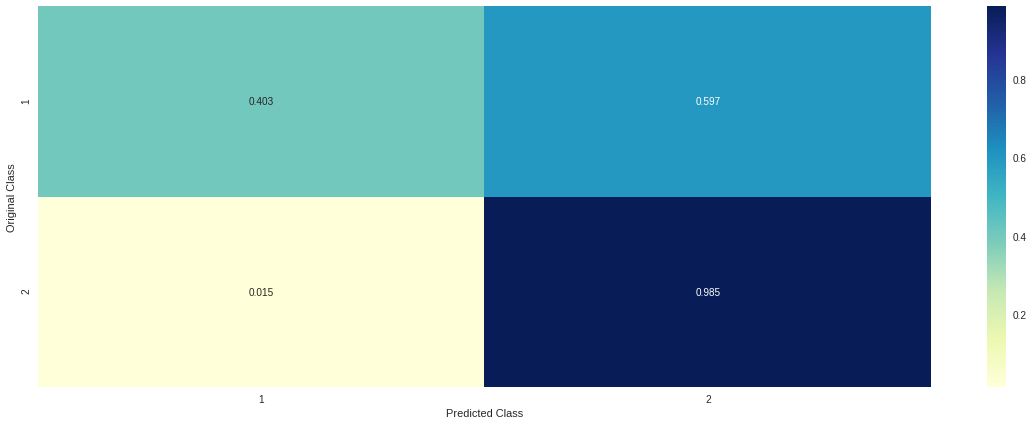

In [0]:
plot_confusion_matrix(Y_test,Y_predict_tfidf)

#BOW

In [0]:
tuned_parameters = [{'max_depth': [4,6,8,10],'n_estimators': [100,500,700,1000]}]

#clf_bow = GradientBoostingClassifier(max_features='log2',min_samples_leaf=4)
clf_bow=XGBClassifier()
model_auc_bow = GridSearchCV(clf_bow,tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')

model_auc_bow.fit(X_train_vect_norm_bow, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [4, 6, 8, 10], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
cv_auc_train_bow = model_auc_bow.cv_results_['mean_train_score']
cv_auc_cv_bow=model_auc_bow.cv_results_['mean_test_score']
print(cv_auc_train_bow)
print(cv_auc_cv_bow)

[0.92698469 0.97995933 0.98653593 0.99196115 0.95436943 0.99247475
 0.99575917 0.9980498  0.97240696 0.99721433 0.99871117 0.9995531
 0.98275942 0.99893275 0.99962166 0.99990833]
[0.88486313 0.91998111 0.92313224 0.9255125  0.89474783 0.92280817
 0.9250756  0.92598507 0.89980225 0.92421262 0.92545281 0.92571171
 0.90227833 0.92279245 0.92392006 0.92386535]


In [0]:
print("Score",model_auc_bow.score(X_test_vect_norm_bow,Y_test))
print("Best parameters",model_auc_bow.best_params_)

Score 0.9175876925580153
Best parameters {'max_depth': 6, 'n_estimators': 1000}


In [0]:
max_depth=[]
n_estimators=[]
for data in model_auc_bow.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  n_estimators.append(data['n_estimators'])

In [0]:
df_train_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_bow': cv_auc_train_bow
    })

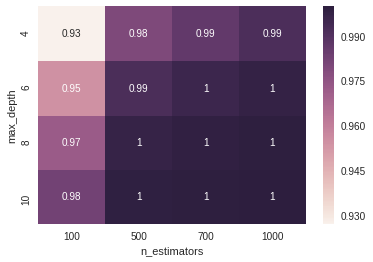

In [0]:
df_train_bow = df_train_bow.pivot("max_depth", "n_estimators", "cv_auc_train_bow")

ax = sns.heatmap(df_train_bow,annot=True)

In [0]:
df_cv_bow = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_bow': cv_auc_cv_bow
    })
df_cv_bow = df_cv_bow.pivot("max_depth", "n_estimators", "cv_auc_cv_bow")

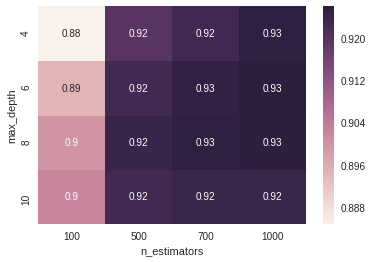

In [0]:
ax = sns.heatmap(df_cv_bow,annot=True)

In [0]:
clf_model_bow = XGBClassifier(max_depth=4,n_estimators=1000)

clf_model_bow.fit(X_train_vect_norm_bow, Y_train)

Y_predict_bow=clf_model_bow.predict(X_test_vect_norm_bow)
Y_prob_bow=clf_model_bow.predict_proba(X_test_vect_norm_bow)

In [0]:
feature_weights_bow=clf_model_bow.feature_importances_
bow_features = count_vect_bow.get_feature_names()

indices_bow = np.argsort(feature_weights_bow)[::-1][:20]

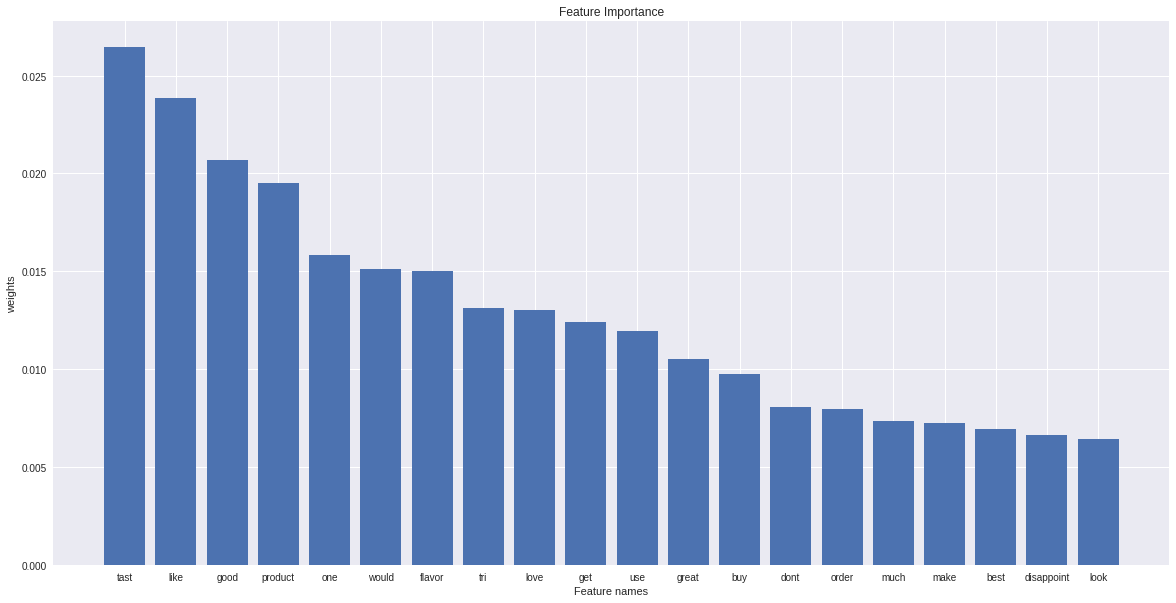

In [0]:
plt.figure(figsize=(20,10))
#plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), feature_weights_bow[indices_bow])
# Add feature names as x-axis labels
bow_features = np.array(bow_features)
plt.xticks(range(20), bow_features[indices_bow])
plt.xlabel('Feature names')
plt.ylabel('weights')
# Show plot
plt.show()
# uni_gram.get_feature_names()

In [0]:
bow_features_arr=[]
for data in indices_bow:
  bow_features_arr.append(bow_features[data])

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(bow_features_arr)) 

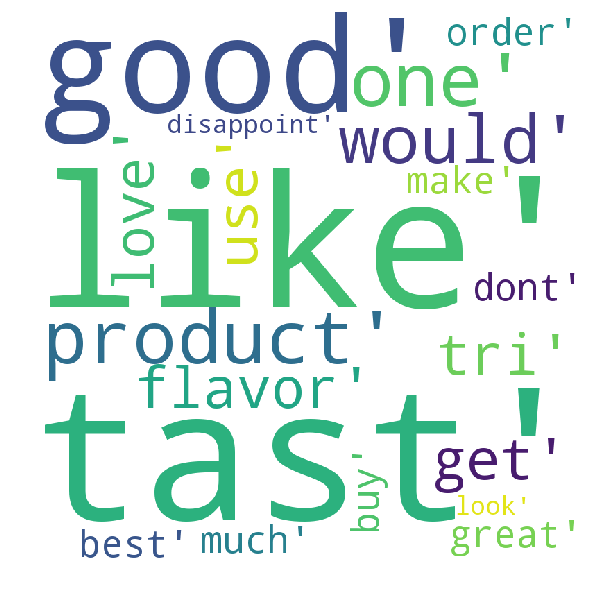

In [0]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_bow[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.9182000789450764


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


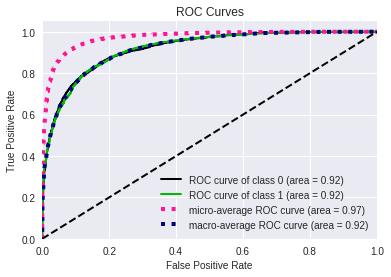

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(Y_test, Y_prob_bow)
plt.show()

-------------------- Confusion matrix --------------------


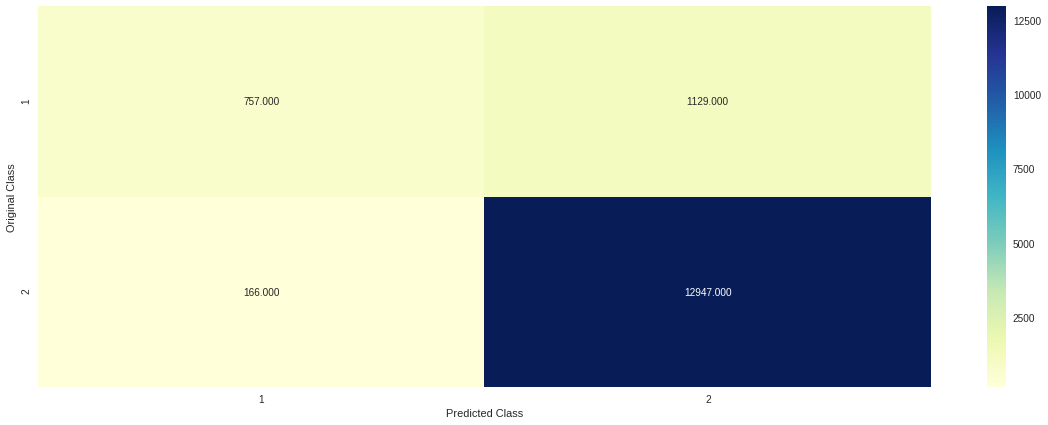

-------------------- Precision matrix (Columm Sum=1) --------------------


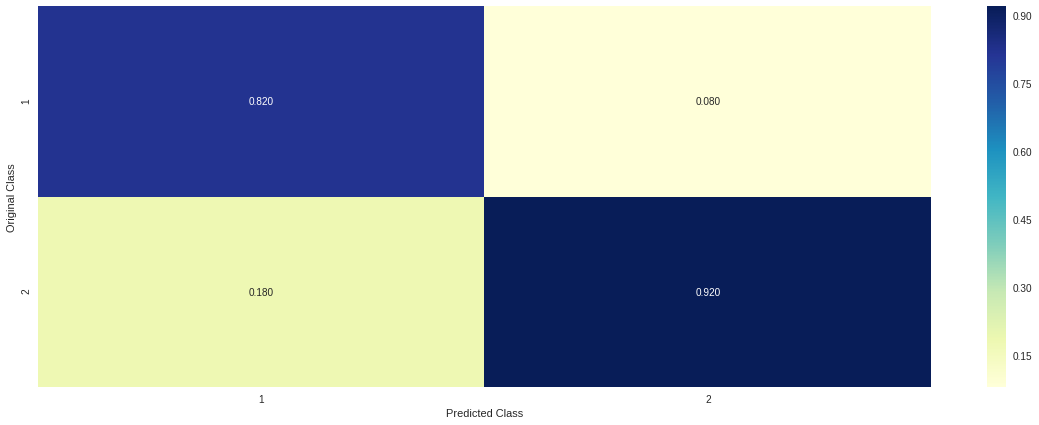

-------------------- Recall matrix (Row sum=1) --------------------


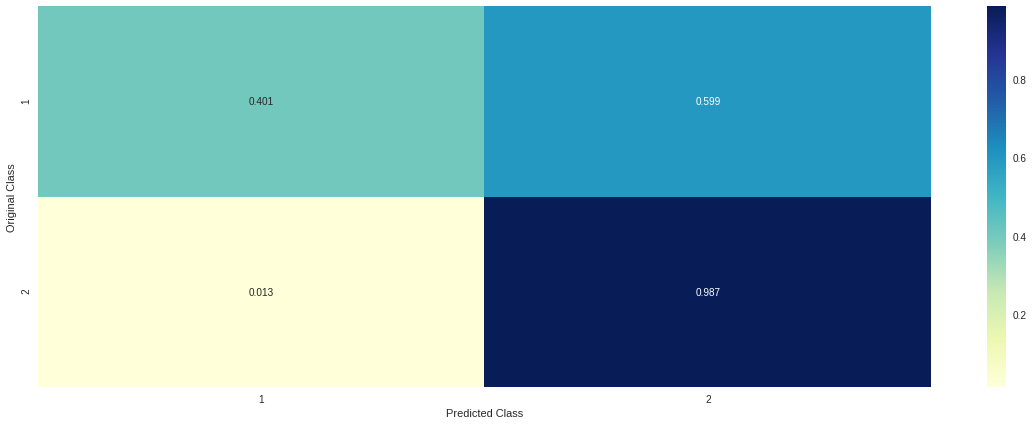

In [0]:
plot_confusion_matrix(Y_test,Y_predict_bow)

#word2vec GBDT

In [0]:
tuned_parameters = [{'max_depth': [4,6,8,10],'n_estimators': [100,500,700,1000]}]

clf_word2vec = XGBClassifier()

model_auc_word2vec = GridSearchCV(clf_word2vec,tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc',n_jobs=-1)
model_auc_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [4, 6, 8, 10], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [0]:
cv_auc_train_word2vec = model_auc_word2vec.cv_results_['mean_train_score']
cv_auc_cv_word2vec=model_auc_word2vec.cv_results_['mean_test_score']
print(cv_auc_train_word2vec)
print(cv_auc_train_word2vec)

[0.93481197 0.98627152 0.99448016 0.99902907 0.98017262 0.99999189
 1.         1.         0.9990296  1.         1.         1.
 0.99999989 1.         1.         1.        ]
[0.93481197 0.98627152 0.99448016 0.99902907 0.98017262 0.99999189
 1.         1.         0.9990296  1.         1.         1.
 0.99999989 1.         1.         1.        ]


In [0]:
print("Score",model_auc_word2vec.score(X_test_vect_norm_word2vec,Y_test))
print("Best parameters",model_auc_word2vec.best_params_)

Score 0.8812284183836736
Best parameters {'max_depth': 10, 'n_estimators': 700}


In [0]:
df_train_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_word2vec': cv_auc_train_word2vec
    })

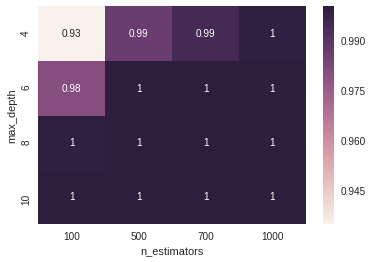

In [0]:
df_train_word2vec = df_train_word2vec.pivot("max_depth", "n_estimators", "cv_auc_train_word2vec")

ax = sns.heatmap(df_train_word2vec,annot=True)

In [0]:
df_cv_word2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_word2vec': cv_auc_cv_word2vec
    })

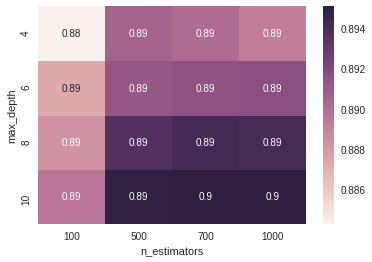

In [0]:
df_cv_word2vec = df_cv_word2vec.pivot("max_depth", "n_estimators", "cv_auc_cv_word2vec")

ax = sns.heatmap(df_cv_word2vec,annot=True)

In [0]:
clf_model_word2vec = XGBClassifier(max_depth=10,n_estimators=1000)

clf_model_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

Y_predict_word2vec=clf_model_word2vec.predict(X_test_vect_norm_word2vec)

Y_prob_word2vec=clf_model_word2vec.predict_proba(X_test_vect_norm_word2vec)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_word2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.8808862987916681


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


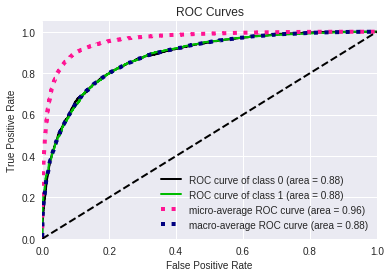

In [0]:
skplt.metrics.plot_roc_curve(Y_test, Y_prob_word2vec)
plt.show()

-------------------- Confusion matrix --------------------


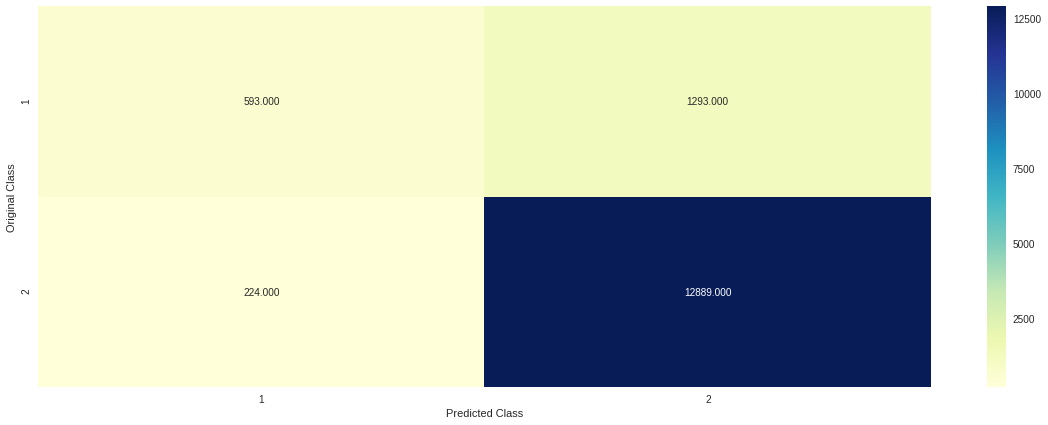

-------------------- Precision matrix (Columm Sum=1) --------------------


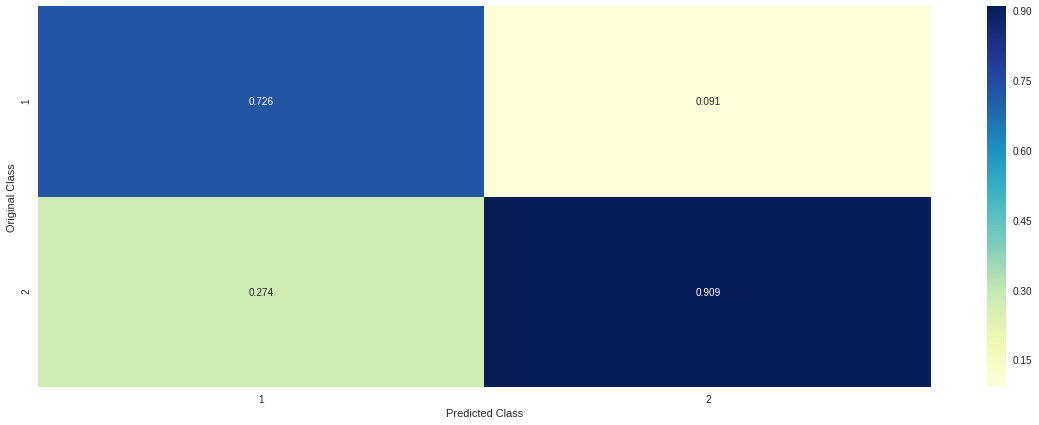

-------------------- Recall matrix (Row sum=1) --------------------


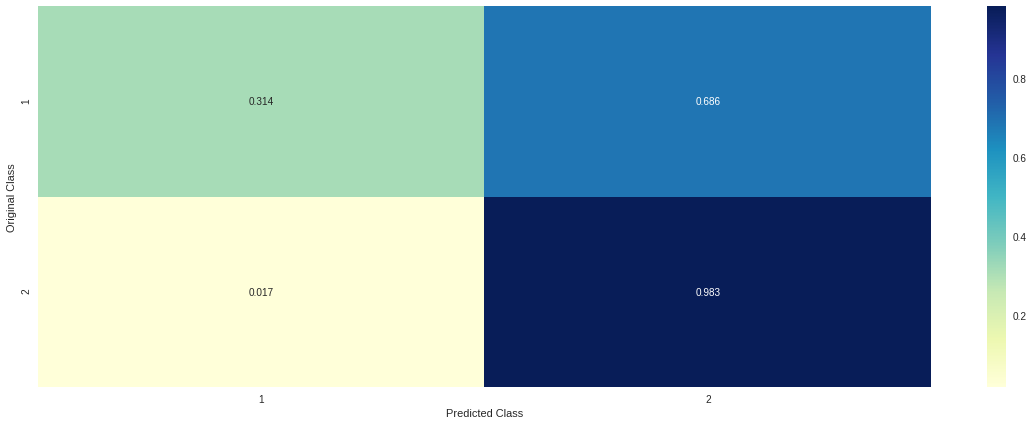

In [0]:
plot_confusion_matrix(Y_test,Y_predict_word2vec)

TFIDFWORD2VEC GBDT

In [45]:
tuned_parameters = [{'max_depth': [4,6,8,10],'n_estimators': [100,500,700,1000]}]

clf_tfidfword2vec = XGBClassifier()

clf_tfidfword2vec = GridSearchCV(clf_tfidfword2vec,tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')
clf_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [4, 6, 8, 10], 'n_estimators': [100, 500, 700, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)

In [46]:
cv_auc_train_tfidfword2vec = clf_tfidfword2vec.cv_results_['mean_train_score']
cv_auc_cv_tfidfword2vec=clf_tfidfword2vec.cv_results_['mean_test_score']
print(cv_auc_train_tfidfword2vec)
print(cv_auc_train_tfidfword2vec)

[0.91913764 0.98034791 0.9908209  0.99793198 0.97445362 0.99994416
 0.99999992 1.         0.99850459 1.         1.         1.
 0.99999871 1.         1.         1.        ]
[0.91913764 0.98034791 0.9908209  0.99793198 0.97445362 0.99994416
 0.99999992 1.         0.99850459 1.         1.         1.
 0.99999871 1.         1.         1.        ]


In [48]:
print("Score",clf_tfidfword2vec.score(tfidf_sent_vectors_test_norm,Y_test))
print("Best parameters",clf_tfidfword2vec.best_params_)

Score 0.855828636618854
Best parameters {'max_depth': 10, 'n_estimators': 1000}


In [0]:
max_depth=[]
n_estimators=[]
for data in clf_tfidfword2vec.cv_results_['params'] :
  max_depth.append(data['max_depth'])    
  n_estimators.append(data['n_estimators'])

In [0]:
df_train_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_train_tfidfword2vec': cv_auc_train_tfidfword2vec
    })

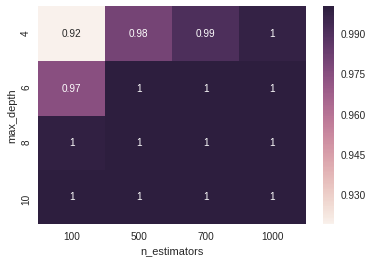

In [56]:
df_train_tfidfword2vec = df_train_tfidfword2vec.pivot("max_depth", "n_estimators", "cv_auc_train_tfidfword2vec")

ax = sns.heatmap(df_train_tfidfword2vec,annot=True)

In [0]:
df_cv_tfidfword2vec = pd.DataFrame(
    {'max_depth': max_depth,
     'n_estimators': n_estimators,
     'cv_auc_cv_tfidfword2vec': cv_auc_cv_tfidfword2vec
    })

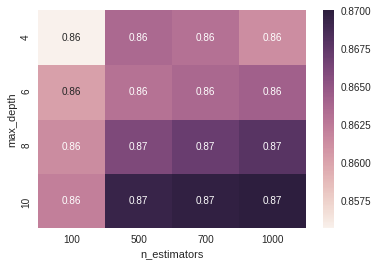

In [58]:
df_cv_tfidfword2vec = df_cv_tfidfword2vec.pivot("max_depth", "n_estimators", "cv_auc_cv_tfidfword2vec")

ax = sns.heatmap(df_cv_tfidfword2vec,annot=True)

In [0]:
clf_model_tfidfword2vec = XGBClassifier(max_depth=10,n_estimators=1000)

clf_model_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

Y_predict_tfidfword2vec=clf_model_tfidfword2vec.predict(tfidf_sent_vectors_test_norm)

Y_prob_tfidfword2vec=clf_model_tfidfword2vec.predict_proba(tfidf_sent_vectors_test_norm)

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob_tfidfword2vec[:,1])
print("AUC",metrics.auc(fpr, tpr))

AUC 0.855828636618854


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


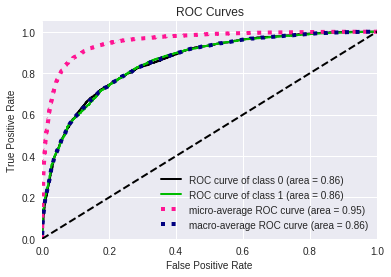

In [63]:
skplt.metrics.plot_roc_curve(Y_test, Y_prob_tfidfword2vec)
plt.show()

-------------------- Confusion matrix --------------------


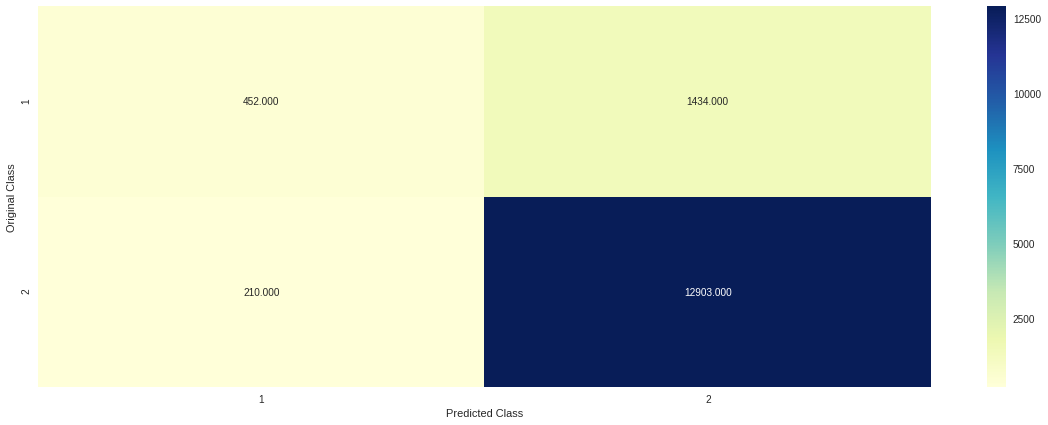

-------------------- Precision matrix (Columm Sum=1) --------------------


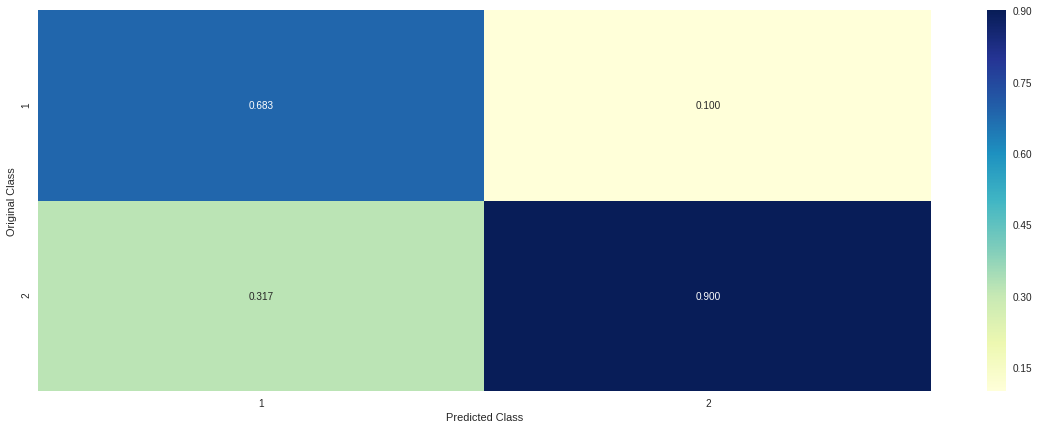

-------------------- Recall matrix (Row sum=1) --------------------


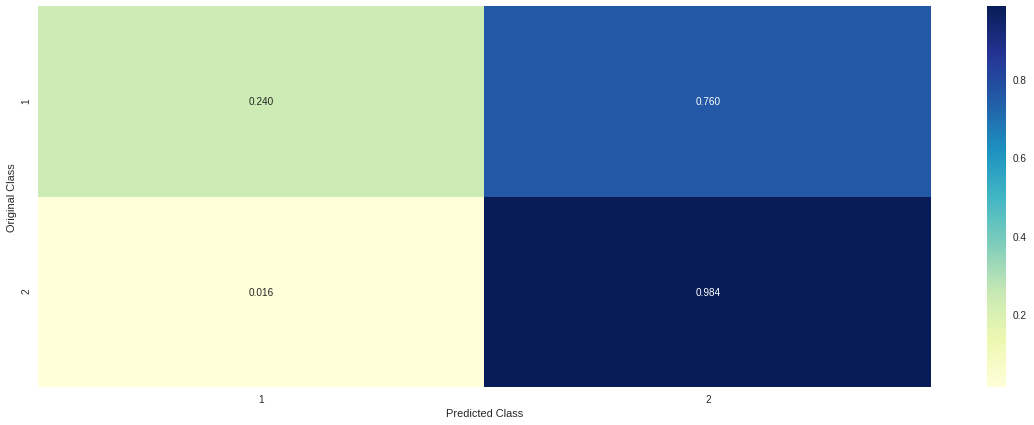

In [64]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

# conclusion

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [0]:
x.field_names = ["Type of vectorizer", "RF AUC","RF best hyperparameter","GDBT AUC","GBDT best hyperparameter"]

In [0]:
x.add_row(["TFIDF","0.898","max_depth=100,n_estimators=700","0.913","max_depth=10,n_estimators=1000"])
x.add_row(["BOW","0.901","max_depth=80,n_estimators=700","0.918","max_depth=4,n_estimators=1000"])
x.add_row(["WORD2VEC","0.8604","max_depth=50,n_estimators=1000","0.875","max_depth=10,n_estimators=1000"])
x.add_row(["TFIDF WORD2VEC","0.830","max_depth=50,n_estimators=1000","0.855","max_depth=10,n_estimators=1000"])

In [68]:
print(x)

+--------------------+--------+--------------------------------+----------+--------------------------------+
| Type of vectorizer | RF AUC |     RF best hyperparameter     | GDBT AUC |    GBDT best hyperparameter    |
+--------------------+--------+--------------------------------+----------+--------------------------------+
|       TFIDF        | 0.898  | max_depth=100,n_estimators=700 |  0.913   | max_depth=10,n_estimators=1000 |
|        BOW         | 0.901  | max_depth=80,n_estimators=700  |  0.918   | max_depth=4,n_estimators=1000  |
|      WORD2VEC      | 0.8604 | max_depth=50,n_estimators=1000 |  0.875   | max_depth=10,n_estimators=1000 |
|   TFIDF WORD2VEC   | 0.830  | max_depth=50,n_estimators=1000 |  0.855   | max_depth=10,n_estimators=1000 |
+--------------------+--------+--------------------------------+----------+--------------------------------+
